In [40]:
"""
To implement:
Move everything into pd DataFrames
    May require multiple for data of different dimensions
        1D: sequence-wise multi-column, 2D: pair-wise multi-column, larger 2D: pairs of pairs multi-column (could also be 4d multi column for compressed dimensions) 
Add multi-chain support
Move Parameters to external settings file
    Step 1: move all settings to a dictionary or class
Implement automatic performance of MSA for DCA
Implement reloading of AV data
Implement optional use of frettraj
"""

###########################
### 1. General settings ###
###########################

settings={}
settings['work_directory'] = \
    r'/zfs/smblab//fduffy/source/repos/FRETNet-Designer/Test/'      # The directory containing the data and structures of interest. Outputs of this code will be saved in subfolders.
settings['output_directory']=settings['work_directory']+'outputs/'  # Subfolder to save output files in. Will be created if it doesn't exist
settings['input_directory']=settings['work_directory']+'inputs/'    # name of a subfolder from a previous run from which things like AVs can be reloaded rather than re-calculated
settings['dependancy_directory'] = \
    r'/zfs/smblab//fduffy/source/repos/FRETNet-Designer/Script_Dependancies' # Directory containing the Python implementation of DCA and other custom functions
settings['input_structures'] = \
    ["RBP_closed_fromSBM+DCA.pdb", "RBP_open_fromSBM+DCA.pdb", "RBP_Twisted_allatom.pdb"] # Input structure files, must be list of strings which are names of files

###########################
### 1.1 Figure settings ###
###########################

settings['figure_parameters']={'legend.fontsize': 'xx-large',
         'figure.figsize': (10, 10),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large',
         'lines.linewidth':1,
         'font.family':'Arial',
         'ps.fonttype':42,
         'pdf.fonttype':42}

#series of settings for whether or not to do a step, or whether to load a previous run or re-perform the action of a module\
#these accept "False" (F), "True" (T), and "Load" (L) for ignoring, performing, or loading a previous run, respectively
#Some parameters accept "Specify" (S), an option like load, but it lets you point to a specific folder/set of files/file to load that was pre-generated, rather than using 
#all outputs from the folder specified in "input"
settings['do_make_MSA']=True #T/F/L/S
settings['do_DCA']=True #T/F/L/S
settings['do_conservation_score']=True #T/F/L/S
settings['Do_AV']=True#'Load' #True or 'Load' or 'Specify'

##########################################
### 2. Domain and Residue Restrictions ###
##########################################

settings['define_domains'] = True                       # defines domains between which sites should be tested. This prevents sites from within the same domains 
                                                        # being tested against one another. this essentially is a time saver, as sites within separate domains 
                                                        # which are mutually re-orienting are likely to provide higher contrast than sites within a single domain
settings['domain_bounds'] = \
        [['Dom1',1,103], ['Dom2',104,271]]               # domain bounds accepts a list of lists containing the domain names, start residue, and end residue (in terms 
                                                         # of the input file indexing). 
                                                         # ['Dom3', 235, 271]] #takes name of domain plus the residue limits in terms of indices loaded by mdtraj
settings['exclude_residues'] = False                     # exluded residues allows particular residues to be excluded. This will remove the residue from any relevant lists if present,
                                                         # but will not perturb the domain definitions,
                                                         # ranges of residues can be specified to be excluded as a list of [start, stop] inclusive. these will be popped out and 
                                                         # generate individual entries into the exclusion list, so this is only for convenience. These are ignorby some analyses, 
                                                         # and those analyses will be performed across the whole sequence. excluded really just marks these sitesed "bad" as if 
                                                         # some parameter eliminated them, such as low SASA.
                                                         # domain bounds really works at the pair level.
settings['excluded_residues'] = [61,151,[152,155], 246]  # in this example, first two entries are redundant with domain bounds, 3rd eliminates a site in domain 2. Currently must feed this a list (even if empty)
if settings['exclude_residues']:
    for i in settings['excluded_residues']:
        if type(i)==int:
            continue
        if type(i)==list:
            settings['excluded_residues'].remove(i)
            settings['excluded_residues'].extend(list(range(i[0],i[1]+1)))
        else:
            raise Exception('Invalid index encountered in exclusion list.')
    settings['excluded_residues'].sort()

############################  
### 3. MSA file settings ###
############################

settings['generate_MSA']=True   # Whether to generate an MSA during run-time or the user will provide a pre-generated MSA file. 
                                # Must ensure correct formating for DCA. Too many MSA formats to account for all of them. 
                                # Sequences should be padded to align exactly along the input structure sequence using '-' placeholder character.
                                # Each sequence should appear on a single line, with lines separated by >header lines.

settings['pregenerated_MSA_file'] = \
        settings['input_directory']+'OutMSA_filtered30.msa'    #location of pregenerated MSA file if generate_MSA == False

###################################################
### 3.1 settings for MSA generation at run-time ###
###################################################

settings['input_seed'] = \
    "Input_Structure_FASTA.fasta"                                       # location of input seed sequence file
settings['outputHMM'] = 'OutHMM.hmm'                                          # ouput HMM file to generate.
settings['database_path'] = \
    '/zfs/smblab/group_software/HMMER/db/Pfam-A.fasta.gz'                     # database location
settings['max_align_gaps'] = 30                                               # max number allowed gaps in sequences to allow for in filtering
settings['outputMSA_filename'] = 'OutMSA.msa'                                 # creates full sequence file with this name as well as filtered with this name +'_filtered<gapnumber>'
settings['hmmer_bin'] = '/zfs/smblab/group_software/HMMER/install/bin/'       # location of hmmer bin for accessing hmmer CLI tools
settings['easel_miniapps'] = \
        '/zfs/smblab/group_software/HMMER/hmmer-3.3.2/easel/miniapps/'        # location of easel miniapps for access to easel CLI tools
settings['filter_pfam_path'] = \
        '/zfs/smblab/fduffy/source/repos/FRETNet-Designer/filter_pfam_args.py' #filter pfam script path

#######################
### 4. DCA settings ###
#######################

settings['pregenerated_DCA']=True                                            # whether DCA was pre-run. if true, need to specify a DCA output file
settings['pregenerated_DCA_file']=settings['output_directory']+'outDCA.dat'
settings['DCA_output']=settings['output_directory']+'outDCA.dat'

###############################
### 5. SASA and AV Settings ###
###############################

settings['contact_cutoff']=.5 #nm. cutoff to convert residue to "bad" residue based on inter-residue contacts. 
settings['SASA_cutoff']=0.2 #nm^2 cutoff below which the low SASA of the residue disqualifies if from labeling
settings['contact_cutoff_mode']='average' #average or individual. Decides whether to check against the average contact or all individually (if all individually, any 1 below threshold discards the residue)
settings['SASA_cutoff_mode']='average' #as above for contacts

settings['generate_dye_parameters_file']=True #True/Load/Specify (need dye parameters for AV sims)
settings['specified_dye_parameters_file']=None

settings['Save_AVs_pkl']=True #Only used if Do_AV=True, saves AVs into a directory as appropriate for reloading
settings['Save_AVs_xyz']=True #only used if Do_AV=True, saves AV xyz files for visualization
settings['AV_label_atom']='CA' #must be an atom all residues have. can add exceptions later
settings['Considered_Atoms']='Local_Labeled_Only' #which atoms to account for in AV simulations. An advanced feature to prevent side chains over-influencing AVs
                                            #can be 'all' - , 
                                            #'Global_Labeled_Only' to only account for the labeled atoms, temporarily deleting all others (similar to Go, 1-bead model)
                                            #'Local_Labeled_Only', temporarily deleting atoms of labeled residue (except labeled atom) and neighboring +/-X residues
                                            #'Backbone_Only', temporarily deletes all non-backbone atoms
settings['Residues_Range_to_Ignore']=1
#below settings are applied as needed to residue positions
settings['basic_dye_parameters']={"Position":
    {"Al488C5": 
        {"linker_length": 20.5,
            "linker_width": 2.5,
            "dye_radius1": 5.0,
            "dye_radius2": 4.5,
            "dye_radius3": 1.5}, #"attach_id": int, attach id left blank as all pairs will have AVs computed, so this will be generated later
    "Al647C2": 
        {"linker_length": 21.0,
            "linker_width": 2.5,
            "dye_radius1": 7.15,
            "dye_radius2": 4.5,
            "dye_radius3": 1.5}, #"attach_id": int, attach id left blank as all pairs will have AVs computed, so this will be generated later
    },
    "Distance": {"Al488C5-Al647C2": 
        {"R0": 52.,
        "n_dist":10000}
    }
}

settings['N_AV_points_mode'] = 'all' #all, average, or none
settings['N_AV_points_threshold'] = 200


if settings['Save_AVs_pkl']==True or settings['Save_AVs_xyz']==True:
    avfoldername='AVs_{0}'.format(settings['Considered_Atoms'])
    if settings['Considered_Atoms']=='Local_Labeled_Only':
        avfoldername=avfoldername+'_'+str(settings['Residues_Range_to_Ignore'])+'_residue_window'
    try:
        os.mkdir(settings['output_directory']+avfoldername)
    except FileExistsError:
        print('AVs Directory exists')
    except:
        print('Something went wrong.')


AVs Directory exists


In [41]:
#%% Import statements

#import subprocess       #used for running bash within Python
import os
import numpy as np      #used for various math functions as well as arrays
import math as m        #math functions
import pandas as pd     #structure output files into useful formats
import matplotlib.pyplot as plt #used for output plots
from matplotlib.colors import LogNorm #useful normalization for many plots' colorscaling
import matplotlib.colors as mcolor
from itertools import combinations #used for generating pairwise combinations of objects, especially residues
#import multiprocessing as mup #for future implementation of parallelization
import json             #used for handling options files for AV sims. Will likely convert these to pandas objects

import mdtraj as md     #used for loading and working with structure files. Alternative packages, with some reworking, would include Bio.PDB
#import avtraj as av     #used for generating accessible volume simulations of fluorophores. However, gives warnings with numba
import fretraj as ft    #alternative used for generating accessible volume simulations of fluorophores. Can also simulate photon traces
import copy
import warnings
import subprocess



os.chdir(settings['dependancy_directory']) #folder containing the scripts needed for this to run
import DCA              #used for direct coupling analysis (DCA), a co-evolution approach to parsing out mutual information between residues that hints at interactions
import ConservationScore #used for single residue conservation score analysis with simple shannon entropy. can add other function options as well



In [3]:
def gaussian(x,u,s,mode='normal'):
    if mode=='normal':
        return np.exp(-.5*((x-u)/s)**2.)*(2*s**2.*np.pi)**(-.5)
    if mode=='peakto1':
        return np.exp(-.5*((x-u)/s)**2.)

In [5]:
#adjust figure output parameters for figures made in matplotlib
import matplotlib.pylab as pylab 
plotparams = {'legend.fontsize': 'xx-large',
         'figure.figsize': (10, 10),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large',
         'lines.linewidth':1,
         'font.family':'Arial',
         'ps.fonttype':42,
         'pdf.fonttype':42}
pylab.rcParams.update(plotparams)

In [36]:
try:
    os.chdir(settings['input_directory'])
except FileNotFoundError:
    os.mkdir(settings['input_directory'])
    os.chdir(settings['input_directory'])

In [7]:
#Pandas DataFrame will contain all single-residue information for each lookup
single_residue_info=pd.DataFrame()
#load the input structures
md_struct=md.load(settings['input_structures'])

In [8]:
#grab residue list from structure. Maintains residue object types
single_residue_info['Residue List']=md_struct.topology._residues
#residue indices
single_residue_info['Residue Index']=[x.resSeq for x in single_residue_info['Residue List']]
#Residue 1 letter codes
single_residue_info['One Letter Code']=[x for x in md_struct.topology.to_fasta()[0]]
#Residue label atom Serial ID
single_residue_info['{0} Serial ID'.format(settings['AV_label_atom'])]=[md_struct[0].top._atoms[i].serial for i in md_struct[0].top.select("name {0}".format(settings['AV_label_atom']))]
#list of residues "good"=True or "bad"=False. Residues converted to bad when some undesirable quality is found at the single residue level
single_residue_info['Good List']=[True for res in range(len(single_residue_info['Residue List']))]
print('#Good={0}'.format(sum(single_residue_info['Good List'])))
#print(single_residue_info.loc[[x in settings['excluded_residues'] for x in single_residue_info['Residue Index']]])
if settings['exclude_residues']:
    single_residue_info.loc[[x in settings['excluded_residues'] for x in single_residue_info['Residue Index']],'Good List']=False
    print('#Good={0}'.format(sum(single_residue_info['Good List'])))
if settings['define_domains']:
    for i in range(len(single_residue_info)):
        if not any([single_residue_info['Residue Index'][i] in x for x in [list(range(y[1],y[2]+1)) for y in settings['domain_bounds']]]):
            single_residue_info['Good List'][i]=False
    print('#Good={0}'.format(sum(single_residue_info['Good List'])))
#define the index of the first residue as a reference for those outputs that index at 0 or 1
first_residue=int(str(list(md_struct.topology.residues)[0])[3:])

#Good=271
#Good=271


In [15]:
#Pandas DataFrame will contain all pair-wise residue information for each pair. 
#length Nx(N-1)/2 (no need to compute self-pair parameters/diagonal of matrix nor degenrate pairs (ie 1-5, 5-1)). 
#Data per column is 1D, should be squareformed for plotting
pair_residue_info=pd.DataFrame()
pair_residue_info['Residue Pair']=list(combinations(single_residue_info['Residue Index'],2)) #given as tuples with indexing as in single_residue_info (original indexing)
pair_residue_info['Good List']=[True for i in range(len(pair_residue_info))]
#make sure pairs span domains. so first, create list of all valid pairs
explicitdomains=[list(range(y[1], y[2]+1)) for y in settings['domain_bounds']]
for j in range(len(explicitdomains)):
    for i in settings['excluded_residues']:
        if i in explicitdomains[j]:
            explicitdomains[j].remove(i)
if settings['define_domains']:        
    domaincombos=combinations(list(range(len(settings['domain_bounds']))),2)
    valid_pairs=[]
    for i in domaincombos:
        valid_pairs.extend([(x,y) for x in explicitdomains[i[0]] for y in explicitdomains[i[1]]])
    for i in range(len(pair_residue_info)):
        if pair_residue_info['Residue Pair'][i] not in valid_pairs:
            pair_residue_info['Good List'][i]=False
print('#Good pairs={0}'.format(sum(pair_residue_info['Good List'])))

/local_scratch/pbs.940644.pbs02/ipykernel_4078235/1514431515.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pair_residue_info['Good List'][i]=False
/local_scratch/pbs.940644.pbs02/ipykernel_4078235/1514431515.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pair_residue_info['Good List'][i]=False
/local_scratch/pbs.940644.pbs02/ipykernel_4078235/1514431515.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pair_residue_info

#Good pairs=16932


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [16]:
try:
    os.chdir(settings['output_directory'])
except FileNotFoundError:
    os.mkdir(settings['output_directory'])
    os.chdir(settings['output_directory'])

In [17]:
#generate a text fasta file for input to external MSA script (header is also added to the file)
with open('Input_Structure_FASTA.fasta','w+') as f:
    f.write('>Input_Structure\n'+md_struct.topology.to_fasta()[0]+'\n')
    f.close()
    


In [13]:
#here, create the MSA file manually as doing so automatically isnt currently implemented

In [14]:
#generate a multi sequence alignment file
#os.chdir(settings['work_directory']+'..')
#if not settings['pregenerated_MSA']:
#    alignmentinputs='no\nInput_Structure_FASTA.fasta\n{0}\n{1}\n{2}\n{3}'.format(settings['get_alignments_outputHMM'],settings['limit_alignment_to_annotated'],settings['max_align_gaps'],settings['get_alignments_outputMSA'])
#    subprocess.run(r'/home/ghamil4/FRET_Design/Rewrite/get_alignments.bash',shell=True,text=True, stdout=subprocess.PIPE, input=alignmentinputs)

In [42]:
#auto generate MSA alignment file when requested
os.chdir('/zfs/smblab/fduffy/source/repos/FRETNet-Designer/')

if  settings['generate_MSA'] == True:
    
    #build hmm using local hmmbuild executable
    command = settings['hmmer_bin'] + 'hmmbuild'
    hmm_name = settings['outputHMM']
    seed_seq = settings['input_seed']
    cmd = [command, hmm_name, seed_seq] 
    subprocess.run(cmd)

    #get alignments using local HMMER executable
    command = settings['hmmer_bin'] + 'hmmsearch'
    flag = '-A'
    hmm_name = hmm_name
    database = settings['database_path']
    cmd = [command, flag, "get_alignments_tempfile1", hmm_name, database] 
    subprocess.run(cmd)

    #reformat alignment file as afa
    command = settings['easel_miniapps'] + 'esl-reformat'
    flag = '-o'
    output_file_name = settings['outputMSA_filename']
    frmt = 'afa'
    cmd = [command, flag, output_file_name, frmt, "get_alignments_tempfile1"] 
    subprocess.run(cmd)

    #filter afa formatted alignment file with python script
    command = 'python'
    script = settings['filter_pfam_path']
    output_file_name = settings['outputMSA_filename']
    max_gaps = '30'
    cmd = [command, script, output_file_name, max_gaps] 
    subprocess.run(cmd)

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.3.2 (Nov 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             Input_Structure_FASTA.fasta
# output HMM file:                  OutHMM.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     Input_Structure_FASTA     1   271   271     0.41  0.587 

# CPU time: 0.38u 0.00s 00:00:00.38 Elapsed: 00:00:00.39


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)






Internal pipeline statistics summary:
-------------------------------------
Query model(s):                            1  (271 nodes)
Target sequences:                   42420656  (6768579590 residues searched)
Passed MSV filter:                   1173848  (0.0276716); expected 848413.1 (0.02)
Passed bias filter:                   853380  (0.0201171); expected 848413.1 (0.02)
Passed Vit filter:                    102388  (0.00241364); expected 42420.7 (0.001)
Passed Fwd filter:                     46578  (0.001098); expected 424.2 (1e-05)
Initial search space (Z):           42420656  [actual number of targets]
Domain search space  (domZ):           36704  [number of targets reported over threshold]
# CPU time: 308.60u 7.51s 00:05:16.11 Elapsed: 00:02:25.16
# Mc/sec: 12636.02
//
# Alignment of 22792 hits satisfying inclusion thresholds saved to: get_alignments_tempfile1
[ok]

Original number of sequences: 22791


Number(%) of sequences excluded: 15142 (66.44%)


File saved as: OutMSA

In [38]:
pwd

'/zfs/smblab/fduffy/source/repos/FRETNet-Designer/Test/inputs'

In [15]:
#while its called inDCA, this is the MSA file used for both DCA and single residue conservation
if settings['generate_MSA'] == True:
    inDCA=settings['outputMSA_filename']+'_filtered{0}'.format(settings['max_align_gaps'])
else:
    inDCA=settings['pregenerated_MSA_file']
    
    

In [16]:
#perform DCA using the generated multi sequence alignment
#counterbalance to single residue conservation, as indicates variability in residue position may be dependent on another co-substitution
if not settings['pregenerated_DCA']:    
    outDCA=settings['DCA_output']
    DCA.dca(inDCA,outDCA)
else:
    outDCA=settings['pregenerated_DCA_file']
DCAresult=np.loadtxt(outDCA)
pair_residue_info['DCA Mutual Info']=DCAresult[:,2]
pair_residue_info['DCA Direct Info']=DCAresult[:,3]
del(DCAresult)

In [17]:
#single residue conservation scoring
#uses simple Shannon entropy metric for the information associated with each residue position
#high information content makes labeling favorable, as the position naturally experiences heterogeneity, so substitutions are favorable
#output file name
settings['output_conservation_score_file']='OutConScore.dat'
#alphabet of supported characters/residues for conservation score analysis. for now, is just native protein AAs+placeholder characters
settings['conservation_alphabet']=['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y','-']

#converts the sequence-wise array to a column-wise list to fead to conservation scorer
columnwise=[col for col in np.array([[res for res in seq] for seq in np.loadtxt(inDCA,dtype='str',usecols=0)[1::2]]).T]

#function takes a single string of characters and computes shannon entropy, so have to feed it columns from MSA.
#computes entropy weighted by the equally-weighted probability of all alphabet entries (1./22. for 22 entries)
ConScores=[ConservationScore.ConservationScore(col,settings['conservation_alphabet'],weight=1.,logbase=m.e) for col in columnwise]
single_residue_info['Conservation Scores']=ConScores

In [18]:
#calculate inter-residue contacts
contacts,contactsindices=md.compute_contacts(md_struct)
maxadder=np.ones((len(contacts),1))*np.max(contacts)
contacts=np.concatenate((maxadder,maxadder,contacts),axis=1)
contactsindices=np.concatenate((np.array([[0,1],[0,2]]),contactsindices))
for i in range(len(pair_residue_info)-4):
    if contactsindices[i][0]<contactsindices[i+1][0] and contactsindices[i][0]<len(single_residue_info)-1:
        contacts=np.concatenate((contacts[:,i+1:],maxadder,maxadder,contacts[:,:i+1]),axis=1)
        contactsindices=np.vstack((contactsindices[:i+1], np.array([[contactsindices[i][0]+1,contactsindices[i][0]+2],[contactsindices[i][0]+1,contactsindices[i][0]+3]]),contactsindices[i+1:]))
contacts=np.concatenate((contacts,maxadder,maxadder,maxadder),axis=1)
contactsindices=np.vstack((contactsindices, np.array([[contactsindices[-1][0]+1,contactsindices[-1][1]-1],[contactsindices[-1][0]+1,contactsindices[-1][1]],[contactsindices[-1][0]+2,contactsindices[-1][1]]])))

la=0
for i in settings['input_structures']:
    pair_residue_info['Contacts '+i+' (nm)']=contacts[la]
    la+=1
del(la)
pair_residue_info['Contacts']=[i for i in contacts.T]
pair_residue_info['Mean Contacts']=np.mean(contacts,axis=0)

In [19]:
#compute solvent-accessible surface area for all residues in all frames
#
SASA=md.shrake_rupley(md_struct,mode='residue')
la=0
for i in settings['input_structures']:
    single_residue_info['SASA ' + i + ' (nm^2)']=SASA[la]
    la+=1
single_residue_info['Mean SASA (nm^2)']=np.mean(SASA,axis=0)
del(la)
del(SASA)

In [20]:
%%capture
#generate AV Parameter file

if settings['generate_dye_parameters_file']==True:
    Dye_Params={'Position':{}}
    Dye_Params['Distance']=settings['basic_dye_parameters']['Distance']
    for i in range(len(single_residue_info)):
        for j in settings['basic_dye_parameters']['Position']:
            Dye_Params['Position']['{0}_'.format(single_residue_info['Residue List'][i])+j]=copy.copy(settings['basic_dye_parameters']['Position'][j])
            Dye_Params['Position']['{0}_'.format(single_residue_info['Residue List'][i])+j]['attach_id']=int(single_residue_info['{0} Serial ID'.format(settings['AV_label_atom'])][i])
    json_file=json.dumps(Dye_Params)
    with open("Dye_Params.json", "w") as outfile:
        outfile.write(json_file)
    Dye_Params_file='Dye_Params.json'
elif settings['generate_dye_parameters_file']=='Load':
    Dye_Params_file='Dye_Params.json'
    with open(Dye_Params_file, 'r') as f:
        Dye_Params=json.load(f)
elif settings['generate_dye_parameters_file']=='Specify':
    Dye_Params_file=settings['specified_dye_parameters_file']
    with open(Dye_Params_file, 'r') as f:
        Dye_Params=json.load(f)    

In [21]:
# mod_struct=copy.copy(md_struct)

In [22]:
# for i in mod_struct.top.atoms:
#     print(i.residue)

In [23]:
# for i in mod_struct.top.residues:
#     print(i)

In [24]:
# list(mod_struct.top.atoms)[188].name=='C'

In [25]:
# list(mod_struct.top.residues)[0].atoms

In [26]:
# [i.serial for i in mod_struct.top.atoms]

In [27]:
# mod_struct.top.delete_atom_by_index(10)


In [28]:
# single_residue_info['Residue List']


In [29]:
# np.where([j not in [True, 2] for j in [True, 2, 3]])

In [30]:
# 'MET61' in [str(i) for i in single_residue_info['Residue List'].iloc[180:500]]

In [31]:
# blah=[False for i in md_struct.top.atoms]
# blah[0]=True
# blah[100]=True
# [i.serial for i in md_struct.atom_slice(np.where(blah)[0]).top._atoms]

In [32]:
# list(single_residue_info['Residue List'].iloc[0:2].astype(str))

In [33]:
# len(md_struct.top._atoms)

In [34]:
# len([j.residue for j in md_struct.top._atoms])

In [35]:
# md_struct.atom_slice(np.where([True for j in md_struct.top.atoms])[0])

In [36]:
# single_residue_info.iloc[i-settings['Residues_Range_to_Ignore']:i+1+settings['Residues_Range_to_Ignore']]

In [37]:
# i=10
# md_struct.atom_slice(np.where([((j.residue not in list(single_residue_info['Residue List'].iloc[i-settings['Residues_Range_to_Ignore']:i+1+settings['Residues_Range_to_Ignore']])) or (j.name=='CA' and j.residue==single_residue_info['Residue List'].iloc[i])) for j in md_struct.top.atoms])[0])
# # [((j.residue not in list(single_residue_info.iloc[i-settings['Residues_Range_to_Ignore']:i+1+settings['Residues_Range_to_Ignore']])) or (j.name=='CA' and j.residue==single_residue_info['Residue List'].iloc[i])) for j in mod_struct.top.atoms ]

In [38]:
# import importlib
# importlib.reload(ft)

In [39]:

#generate AVs for all sites

temp1=[] 
temp2=[]
Mod_Dye_Params_file='Mod_'+Dye_Params_file
if settings['Do_AV']==True:
    mod_struct=copy.copy(md_struct) #generate a modified structure based on the desired considerations for av simulations
    
            
    if settings['Considered_Atoms']=='Global_Labeled_Only': #for these two, can do the modification ahead of time so we don't have to read/write so often
        #also have to re-assign the attachment atom IDs s.t. they correspond to the new serialized indices
        with open(Dye_Params_file,'r') as f:
            Mod_Dye_Params=json.load(f)
        mod_struct=copy.copy(md_struct.atom_slice(np.where([i.name==settings['AV_label_atom'] for i in mod_struct.top.atoms])[0]))
        
        with open(Mod_Dye_Params_file, 'w') as f:
            f.write(json.dumps(Mod_Dye_Params))
        labels=ft.cloud.labeling_params(Mod_Dye_Params_file, verbose=False)
        
    elif settings['Considered_Atoms']=='Backbone_Only':
        
        #also have to re-assign the attachment atom IDs s.t. they correspond to the new serialized indices
        with open(Dye_Params_file,'r') as f:
            Mod_Dye_Params=json.load(f)

        mod_struct=copy.copy(md_struct.atom_slice(np.where([i.is_backbone for i in mod_struct.top.atoms])[0]))
        with open(Mod_Dye_Params_file, 'w') as f:
            f.write(json.dumps(Mod_Dye_Params))    
            
        labels=ft.cloud.labeling_params(Mod_Dye_Params_file, verbose=False)
    #for i in range(87,90):#
    for i in range(len(single_residue_info)):
        print(single_residue_info['Residue List'].iloc[i])
        if settings['Considered_Atoms']=='all':
            labels=ft.cloud.labeling_params(Mod_Dye_Params_file, verbose=False)
            AVs1=ft.cloud.Volume.from_frames(mod_struct, str(single_residue_info['Residue List'][i])+'_'+list(settings['basic_dye_parameters']['Position'].keys())[0], labels,np.arange(len(md_struct)))
            AVs2=ft.cloud.Volume.from_frames(mod_struct, str(single_residue_info['Residue List'][i])+'_'+list(settings['basic_dye_parameters']['Position'].keys())[1], labels,np.arange(len(md_struct)))
        elif settings['Considered_Atoms']=='Global_Labeled_Only' or settings['Considered_Atoms']=='Backbone_Only':
            AVs1=ft.cloud.Volume.from_frames(mod_struct, str(single_residue_info['Residue List'][i])+'_'+list(settings['basic_dye_parameters']['Position'].keys())[0], labels,np.arange(len(md_struct)))
            AVs2=ft.cloud.Volume.from_frames(mod_struct, str(single_residue_info['Residue List'][i])+'_'+list(settings['basic_dye_parameters']['Position'].keys())[1], labels,np.arange(len(md_struct)))

        elif settings['Considered_Atoms']=='Local_Labeled_Only':
            #have to do the modifications on a per-residue basis here, so must reload mod_struct each time
            mod_struct=copy.copy(md_struct)
            #also have to re-assign the attachment atom IDs s.t. they correspond to the new serialized indices, and do so for each new residue
            with open(Dye_Params_file,'r') as f:
                Mod_Dye_Params=json.load(f)
            tempresname=str(list(mod_struct.top.residues)[i])
            if i < settings['Residues_Range_to_Ignore']:
                mod_struct=copy.copy(md_struct.atom_slice(np.where([((j.residue not in list(single_residue_info['Residue List'].iloc[0:i+1+settings['Residues_Range_to_Ignore']])) or (j.name=='CA' and j.residue==single_residue_info['Residue List'].iloc[i])) for j in md_struct.top.atoms])[0]))
            else:
                mod_struct=copy.copy(md_struct.atom_slice(np.where([((j.residue not in list(single_residue_info['Residue List'].iloc[i-settings['Residues_Range_to_Ignore']:i+1+settings['Residues_Range_to_Ignore']])) or (j.name=='CA' and j.residue==single_residue_info['Residue List'].iloc[i])) for j in md_struct.top.atoms])[0]))
            
            with open(Mod_Dye_Params_file, 'w') as f:
                f.write(json.dumps(Mod_Dye_Params))                 
                            
            labels=ft.cloud.labeling_params(Mod_Dye_Params_file, verbose=False)
            AVs1=ft.cloud.Volume.from_frames(mod_struct, str(single_residue_info['Residue List'][i])+'_'+list(settings['basic_dye_parameters']['Position'].keys())[0], labels,np.arange(len(md_struct)))
            AVs2=ft.cloud.Volume.from_frames(mod_struct, str(single_residue_info['Residue List'][i])+'_'+list(settings['basic_dye_parameters']['Position'].keys())[1], labels,np.arange(len(md_struct)))
            
            del(tempresname)
        temp1.append(AVs1)
        temp2.append(AVs2)
    
        with warnings.catch_warnings(record=True):
            if settings['Save_AVs_pkl']==True:
                os.chdir(settings['output_directory']+avfoldername)
                try:
                    ft.cloud.save_obj(r'AVs1_{0}.pkl'.format(single_residue_info['Residue List'][i]), AVs1)
                except:
                    print('AV1 of {0} is empty in at least one frame, not saving'.format(single_residue_info['Residue List'][i]))
                try:
                    ft.cloud.save_obj(r'AVs2_{0}.pkl'.format(single_residue_info['Residue List'][i]), AVs2)
                except:
                    print('AV2 of {0} is empty in at least one frame, not saving'.format(single_residue_info['Residue List'][i]))
                os.chdir(settings['output_directory'])
            if settings['Save_AVs_xyz']==True:
                os.chdir(settings['output_directory']+avfoldername)
                try:
                    ft.cloud.save_acv_traj(r'AVs1_{0}.xyz'.format(single_residue_info['Residue List'][i]), AVs1, format='xyz')
                except:
                    print('AV1 of {0} is empty in at least one frame, not saving'.format(single_residue_info['Residue List'][i]))
                try:
                    ft.cloud.save_acv_traj(r'AVs2_{0}.xyz'.format(single_residue_info['Residue List'][i]), AVs2, format='xyz')   
                except:
                    print('AV2 of {0} is empty in at least one frame, not saving'.format(single_residue_info['Residue List'][i]))
                os.chdir(settings['output_directory'])
    # del(mod_struct)
elif settings['Do_AV']=='Load':
    labels=ft.cloud.labeling_params(Mod_Dye_Params_file, verbose=False)
    for i in range(len(single_residue_info)):
        os.chdir(settings['output_directory']+avfoldername)
        try:
            AVs1=ft.cloud.load_obj(r'AVs1_{0}.pkl'.format(single_residue_info['Residue List'][i]))
        except:
            print('AV1 of {0} file does not exist, was either empty or never saved. Will append None.'.format(single_residue_info['Residue List'][i]))
            AVs1=None
        try:
            AVs2=ft.cloud.load_obj(r'AVs2_{0}.pkl'.format(single_residue_info['Residue List'][i]))
        except:
            print('AV2 of {0} file does not exist, was either empty or never saved. Will append None.'.format(single_residue_info['Residue List'][i]))
            AVs2=None
        os.chdir(settings['output_directory'])
        temp1.append(AVs1)
        temp2.append(AVs2)
    
single_residue_info[list(settings['basic_dye_parameters']['Position'].keys())[0]+'_AVs']=temp1
single_residue_info[list(settings['basic_dye_parameters']['Position'].keys())[1]+'_AVs']=temp2
del(temp1)
del(temp2)



LYS1
1rogress: |--------------------| 0% complete
0 2245 LYS1-CA
1rogress: |██████--------------| 33% complete
0 2245 LYS1-CA
1rogress: |█████████████-------| 67% complete
0 2245 LYS1-CA
Progress: |████████████████████| 100% complete
1rogress: |--------------------| 0% complete
0 2245 LYS1-CA
1rogress: |██████--------------| 33% complete
0 2245 LYS1-CA
1rogress: |█████████████-------| 67% complete
0 2245 LYS1-CA
Progress: |████████████████████| 100% complete
ASP2
1rogress: |--------------------| 0% complete
0 2237 ASP2-CA
1rogress: |██████--------------| 33% complete
0 2237 ASP2-CA
1rogress: |█████████████-------| 67% complete
0 2237 ASP2-CA
Progress: |████████████████████| 100% complete
1rogress: |--------------------| 0% complete
0 2237 ASP2-CA
1rogress: |██████--------------| 33% complete
0 2237 ASP2-CA
1rogress: |█████████████-------| 67% complete
0 2237 ASP2-CA
Progress: |████████████████████| 100% complete
THR3
11ogress: |--------------------| 0% complete
10 2238 THR3-CA
11ogress

In [40]:
#check if mdtraj atom selection supports 'serial'
#and/or if 'index' is maintained

In [41]:
# md_struct.top.select("index 10")

In [42]:
# md_struct.top._atoms[9].serial

In [43]:
# mod_struct.top._atoms[1].serial

In [44]:
# [i.index for i in mod_struct.top.atoms if i.serial==single_residue_info['CA Serial ID'][31]][0]

In [45]:
# [labels['Position'][j]['attach_id'] in [i.serial for i in mod_struct.top.atoms] for j in labels['Position']]
# [i.serial for i in mod_struct.top.atoms].index(1410)

In [46]:
# single_residue_info

In [47]:
# labels

In [48]:
# [i.serial==(labels["Position"][site]["attach_id"]) for i in self.structure.top.atoms].index(True)

In [49]:
# md_struct.top._atoms[20]

In [50]:

# mod_struct.top._atoms[2]

In [51]:
# md_struct.top._atoms[18]

In [52]:
# mod_struct.top._atoms==md_struct.top._atoms

In [53]:
%%capture
#check integrated density in AV

temp1=[]
temp2=[]

for i in range(len(single_residue_info)):
    temper1=[]
    temper2=[]
    for j in single_residue_info[list(settings['basic_dye_parameters']['Position'].keys())[0]+'_AVs'][i]:
        try:
            temper1.append(sum(j.acv.grid_1d))
            #temper2.append(sum(j.acv.cloud_xyzqt[:,4]))
        except:
            temper1.append(0)
    for j in single_residue_info[list(settings['basic_dye_parameters']['Position'].keys())[1]+'_AVs'][i]:
        try:
            temper2.append(sum(j.acv.grid_1d))
            #temper2.append(sum(j.acv.cloud_xyzqt[:,4]))
        except:
            temper2.append(0)
    temp1.append(np.array(temper1))
    temp2.append(np.array(temper2))

single_residue_info[list(settings['basic_dye_parameters']['Position'].keys())[0]+'_grid1dsum']=temp1
single_residue_info[list(settings['basic_dye_parameters']['Position'].keys())[1]+'_grid1dsum']=temp2
single_residue_info['avg_'+list(settings['basic_dye_parameters']['Position'].keys())[0]+'_grid1dsum']=[np.mean(i) for i in temp1]
single_residue_info['avg_'+list(settings['basic_dye_parameters']['Position'].keys())[1]+'_grid1dsum']=[np.mean(i) for i in temp2]
del(temp1)
del(temp2)

In [54]:
print(temper1)

[19753.333333332677, 18805.666666666875, 16968.666666667]


In [55]:
#threshold the above densities
if settings['N_AV_points_mode'] == 'all':
    for i in range(len(single_residue_info)):
        if any(single_residue_info[list(settings['basic_dye_parameters']['Position'].keys())[0]+'_grid1dsum'][i]<settings['N_AV_points_threshold']):
            single_residue_info['Good List'][i] = False
            #print('setting {0} false'.format(i))
            
elif settings['N_AV_points_mode'] == 'average':
    for i in range(len(single_residue_info)):
        if np.mean(single_residue_info[list(settings['basic_dye_parameters']['Position'].keys())[0]+'_grid1dsum'][i])<settings['N_AV_points_threshold']:
            single_residue_info['Good List'][i] = False

else:
    print('Skipping elimination based on number of AV points')
print('#Good={0}'.format(sum(single_residue_info['Good List'])))

#Good=256


/local_scratch/pbs.890155.pbs02/ipykernel_433612/3842978255.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  single_residue_info['Good List'][i] = False
/local_scratch/pbs.890155.pbs02/ipykernel_433612/3842978255.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  single_residue_info['Good List'][i] = False
/local_scratch/pbs.890155.pbs02/ipykernel_433612/3842978255.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  single_residue_

In [56]:
print(single_residue_info)

    Residue List  Residue Index One Letter Code  CA Serial ID  Good List  \
0           LYS1              1               K             3       True   
1           ASP2              2               D            13       True   
2           THR3              3               T            22       True   
3           ILE4              4               I            30       True   
4           ALA5              5               A            39       True   
..           ...            ...             ...           ...        ...   
266       LEU267            267               L          2221       True   
267       VAL268            268               V          2230       True   
268       VAL269            269               V          2238       True   
269       LYS270            270               K          2246       True   
270       GLN271            271               Q          2256       True   

     Conservation Scores  SASA RBP_open_fromSBM+DCA.pdb (nm^2)  \
0              -0.768

In [57]:
single_residue_info['Al488C5_AVs'].iloc[1][0].acv.__dict__.keys()

dict_keys(['n_gridpts', 'grid_1d', 'tag_1d', 'grid_3d', 'tag_3d', 'cloud_xyzqt', 'll_Grid3D', 'mp'])

In [58]:
#debug: checking to see how many entires are in the data frame
print(single_residue_info['Al488C5_AVs'])

0      [<fretraj.cloud.Volume object at 0x1477b3061e2...
1      [<fretraj.cloud.Volume object at 0x1477abfcfe5...
2      [<fretraj.cloud.Volume object at 0x1477b03f722...
3      [<fretraj.cloud.Volume object at 0x1477abaa56a...
4      [<fretraj.cloud.Volume object at 0x1477b108ec1...
                             ...                        
266    [<fretraj.cloud.Volume object at 0x14778a1e037...
267    [<fretraj.cloud.Volume object at 0x14779d2ad40...
268    [<fretraj.cloud.Volume object at 0x147797eb02b...
269    [<fretraj.cloud.Volume object at 0x14778b8e513...
270    [<fretraj.cloud.Volume object at 0x14778ec0b8b...
Name: Al488C5_AVs, Length: 271, dtype: object


In [59]:
#debug: checking to see at what point in the for loop does the NoneType error get thrown.
for j in [i[0] for i in single_residue_info['Al488C5_AVs']]:
    print(j.acv) #shows which j.acv objects are NoneType. 
    #sum(j.acv.grid_1d)

(array([18.,  9., 12., 13., 17., 17., 13., 12., 14., 24., 24., 23., 16.,
        10., 15., 11., 10.,  8.,  2.,  3.]),
 array([1.33333333e+01, 1.08271667e+03, 2.15210000e+03, 3.22148333e+03,
        4.29086667e+03, 5.36025000e+03, 6.42963333e+03, 7.49901667e+03,
        8.56840000e+03, 9.63778333e+03, 1.07071667e+04, 1.17765500e+04,
        1.28459333e+04, 1.39153167e+04, 1.49847000e+04, 1.60540833e+04,
        1.71234667e+04, 1.81928500e+04, 1.92622333e+04, 2.03316167e+04,
        2.14010000e+04]),
 <BarContainer object of 20 artists>)

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

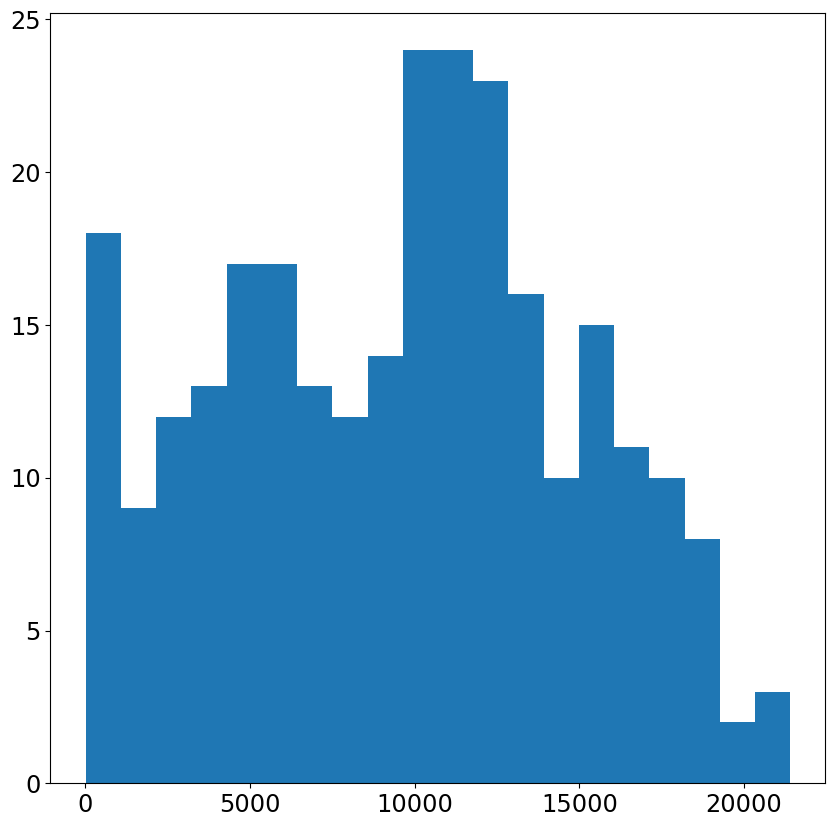

In [60]:
plt.hist([sum(j.acv.grid_1d) for j in [i[0] for i in single_residue_info['Al488C5_AVs']]], bins=20)

In [61]:
#make sure that both residues in each pair are still in the single residue "good list"
for i in range(len(pair_residue_info)):
    if not (pair_residue_info['Residue Pair'][i][0] in single_residue_info[single_residue_info['Good List']]['Residue Index'].tolist()):
        pair_residue_info['Good List'][i] = False
        continue
    if not (pair_residue_info['Residue Pair'][i][1] in single_residue_info[single_residue_info['Good List']]['Residue Index'].tolist()):
        pair_residue_info['Good List'][i] = False
print('#Good={0}'.format(sum(single_residue_info['Good List'])))
print('#Good pairs={0}'.format(sum(pair_residue_info['Good List'])))

/local_scratch/pbs.890155.pbs02/ipykernel_433612/563310046.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pair_residue_info['Good List'][i] = False
/local_scratch/pbs.890155.pbs02/ipykernel_433612/563310046.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pair_residue_info['Good List'][i] = False
/local_scratch/pbs.890155.pbs02/ipykernel_433612/563310046.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pair_residue_info['Goo

#Good=256
#Good pairs=15010


In [62]:
pair_residue_info[pair_residue_info['Good List']].iloc[-1]

Residue Pair                                                                     (103, 271)
Good List                                                                              True
DCA Mutual Info                                                                    0.006876
DCA Direct Info                                                                    0.000644
Contacts RBP_open_fromSBM+DCA.pdb (nm)                                             4.521051
Contacts RBP_Twisted_allatom.pdb (nm)                                              4.551577
Contacts                                  [4.521050930023193, 4.551577091217041, 4.08702...
Mean Contacts                                                                       4.38655
Name: 22556, dtype: object

In [63]:

#only does the calculations as dye1-dye2:res1-res2 for now, but could incorporate directed calculations easily as all AVs calculated already
#can add option to only do attachment atom distances if FRET info not available

tempFRETs=[]
tempRmp_vec=[] #vectorial Rmp between AV clouds, calculated as RAV2-RAV1
tempRatt_vec=[] #same, but between attachment atoms

for i in range(len(pair_residue_info)):    
    if pair_residue_info['Good List'][i]==True:
        tempFRETs.append(ft.cloud.FRET.from_volumes(single_residue_info['{0}_AVs'.format(list(settings['basic_dye_parameters']['Position'].keys())[0])][single_residue_info['Residue Index']==pair_residue_info['Residue Pair'][i][0]].iloc[0],single_residue_info['{0}_AVs'.format(list(settings['basic_dye_parameters']['Position'].keys())[1])][single_residue_info['Residue Index']==pair_residue_info['Residue Pair'][i][1]].iloc[0],list(settings['basic_dye_parameters']['Distance'].keys())[0],labels))    
        tempRmp_vec.append([k.acv.mp-j.acv.mp for j, k in zip(single_residue_info['{0}_AVs'.format(list(settings['basic_dye_parameters']['Position'].keys())[0])][single_residue_info['Residue Index']==pair_residue_info['Residue Pair'][i][0]].iloc[0], single_residue_info['{0}_AVs'.format(list(settings['basic_dye_parameters']['Position'].keys())[0])][single_residue_info['Residue Index']==pair_residue_info['Residue Pair'][i][1]].iloc[0])])
        tempRatt_vec.append([k.av.attach_xyz-j.av.attach_xyz for j, k in zip(single_residue_info['{0}_AVs'.format(list(settings['basic_dye_parameters']['Position'].keys())[0])][single_residue_info['Residue Index']==pair_residue_info['Residue Pair'][i][0]].iloc[0], single_residue_info['{0}_AVs'.format(list(settings['basic_dye_parameters']['Position'].keys())[0])][single_residue_info['Residue Index']==pair_residue_info['Residue Pair'][i][1]].iloc[0])])
    else:
        tempFRETs.append(None)  
        tempRmp_vec.append(None)  
        tempRatt_vec.append(None)  
pair_residue_info['{0}-{1}_FRET'.format(list(settings['basic_dye_parameters']['Position'].keys())[0],list(settings['basic_dye_parameters']['Position'].keys())[1])]=tempFRETs
pair_residue_info['Rmp_vec'.format(list(settings['basic_dye_parameters']['Position'].keys())[0],list(settings['basic_dye_parameters']['Position'].keys())[1])]=tempRmp_vec
pair_residue_info['Ratt_vec'.format(list(settings['basic_dye_parameters']['Position'].keys())[0],list(settings['basic_dye_parameters']['Position'].keys())[1])]=tempRatt_vec
del(tempFRETs)
del(tempRmp_vec)
del(tempRatt_vec)

Progress: |████████████████████| 100% complete
Progress: |████████████████████| 100% complete
Progress: |████████████████████| 100% complete
Progress: |████████████████████| 100% complete
Progress: |████████████████████| 100% complete
Progress: |████████████████████| 100% complete
Progress: |████████████████████| 100% complete
Progress: |████████████████████| 100% complete
Progress: |████████████████████| 100% complete
Progress: |████████████████████| 100% complete
Progress: |████████████████████| 100% complete
Progress: |████████████████████| 100% complete
Progress: |████████████████████| 100% complete
Progress: |████████████████████| 100% complete
Progress: |████████████████████| 100% complete
Progress: |████████████████████| 100% complete
Progress: |████████████████████| 100% complete
Progress: |████████████████████| 100% complete
Progress: |████████████████████| 100% complete
Progress: |████████████████████| 100% complete
Progress: |████████████████████| 100% complete
Progress: |██

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [64]:
#Now, add columns for the Rmp, R_DA, E, etc. and all the indicidual FRET eff params are done
#Then, contrast between states. DrRMP, DrAXYZs, Dots vetween DrRMP, DrAXYZ (do not do dot of Rmp1 vs Rmp2, as this is sensitive to rotations of the whole molecule, nor of rRMP and rAXYZ as this just tells about height of MP off surface)
#last, score individual pairs (and residues)
#now, construct network (this should be done with scoring or via max information -- possible implementation in constructing whole networks and picking one with high total info score, but mb slow)

In [65]:
dist_types=['mean_R_DA', 'sigma_R_DA', 'mean_E_DA', 'sigma_E_DA', 'mean_R_DA_E', 'sigma_R_DA_E', 'R_attach', 'R_mp']
#sigma is the std of the sampled distances WITHIN A GIVEN STATE FROM THAT STATES AV CLOUD
tempdists={i:[] for i in dist_types}

#these stds are the stds of the means amongst all states (how much the metric changes as conformation changes)
for i in dist_types:
    tempdists['std_'+i]=[]

for i in range(len(pair_residue_info)):
    if pair_residue_info['Good List'][i]==True:
        for j in dist_types:
            temp=[eval('i.{0}'.format(j)) for i in pair_residue_info['{0}-{1}_FRET'.format(list(settings['basic_dye_parameters']['Position'].keys())[0],list(settings['basic_dye_parameters']['Position'].keys())[1])][i]]
            tempdists[j].append(temp)
            tempdists['std_'+j].append(np.std(temp))
    else:
        for j in dist_types:
            tempdists[j].append(None)
            tempdists['std_'+j].append(None)
            
for i in tempdists:
    pair_residue_info[i]=tempdists[i]
del(tempdists)

In [66]:
def Dynamic_Shift(E1, E2):
    return 2.**(-.5)*((1.-E1)**.5-(1.-E2)**.5)**2.

def Contrast_Fun(a, b, mode='Dynamic_Shift', scale=1.):
    if mode=='Dynamic_Shift':
        con=Dynamic_Shift(a,b)
    if mode=='Energy_Gaussian':
        con=gaussian(a-b, 0, scale)
    if mode=='Energy_InverseR':
        con=scale*abs(a-b)**-1.
    return con

In [67]:
#compute representative stats for changes in distance metric 
contrast_types=['mean_R_DA', 'mean_E_DA', 'mean_R_DA_E', 'R_attach', 'R_mp']
custom_contrast=['Dynamic_Shift', 'Energy_InverseR', 'Energy_Gaussian'] #must be None, or some combo of 'Dynamic_Shift', 'Energy_InverseR', and 'Energy_Gaussian' in a list

tempcons={'d_'+i:[] for i in contrast_types}
#have to handle the dot product and dynamic shift bits separately
tempcons['d_Rmp_vec']=[]
tempcons['d_Ratt_vec']=[]
#dot product is absolute value as we just want to see ANY change in Rda wrt Rattach
tempcons['dRmpDOTdRatt']=[]
if custom_contrast is not None:
    for j in custom_contrast:
        tempcons[j]=[]

#this is the average of the contrast metric differences between frames
temp_avgdifs={'avg_d_'+i:[] for i in contrast_types}
temp_avgdifs['avg_dRmpDOTdRatt']=[]
if custom_contrast is not None:
    for j in custom_contrast:
        temp_avgdifs['avg_'+j]=[]

for i in range(len(pair_residue_info)):
    if pair_residue_info['Good List'][i]==True:
        for j in contrast_types:
            temp=[abs(l-k) for k, l in combinations(pair_residue_info[j][i], 2)]
            tempcons['d_'+j].append(temp)
            temp_avgdifs['avg_d_'+j].append(np.mean(temp))
        tempcons['d_Rmp_vec'].append([l-k for k, l in combinations(pair_residue_info['Rmp_vec'][i], 2)])
        tempcons['d_Ratt_vec'].append([l-k for k, l in combinations(pair_residue_info['Ratt_vec'][i], 2)])
        tempcons['dRmpDOTdRatt'].append([abs(np.sum(k*l))/(np.sum(k**2.)**.5)/(np.sum(l**2.)**.5) for k, l in zip(tempcons['d_Rmp_vec'][-1],tempcons['d_Ratt_vec'][-1])])
        #tempcons['dRmpDOTdRatt'].append([np.dot(k/(np.sum(k**2.)**.5), (l/np.sum(l**2.)**.5)) for k, l in zip(tempcons['d_Rmp_vec'][-1],tempcons['d_Ratt_vec'][-1])])
        temp_avgdifs['avg_dRmpDOTdRatt'].append(np.mean(tempcons['dRmpDOTdRatt'][-1]))
        if custom_contrast is not None:
            for m in custom_contrast:
                tempcons[m].append([Contrast_Fun(k, l, m, scale=1./len(pair_residue_info['mean_E_DA'][i])) for k, l in combinations(pair_residue_info['mean_E_DA'][i], 2)])
                temp_avgdifs['avg_'+m].append(np.mean(tempcons[m][-1]))    
        
    else:
        for j in contrast_types:
            tempcons['d_'+j].append(None)
            temp_avgdifs['avg_d_'+j].append(None)
        tempcons['d_Rmp_vec'].append(None)
        tempcons['d_Ratt_vec'].append(None)
        tempcons['dRmpDOTdRatt'].append(None)
        temp_avgdifs['avg_dRmpDOTdRatt'].append(None)
        if custom_contrast is not None:
            for m in custom_contrast:
                tempcons[m].append(None)
                temp_avgdifs['avg_'+m].append(None)    

for i in tempcons:
    pair_residue_info[i]=tempcons[i]
for i in temp_avgdifs:
    pair_residue_info[i]=temp_avgdifs[i]
        
del(tempcons)
del(temp_avgdifs)

In [68]:
proximity_penalty_scale=10.
pair_residue_info['Sequence Proximity Penalty']=[gaussian(i[0]-i[1], 0, proximity_penalty_scale, 'peakto1') for i in pair_residue_info['Residue Pair']]

In [69]:
#score function
def std_0to1(data):
    return (data-np.min(data))/(np.max(data)-np.min(data))
def std_Zscore(data):
    return (data-np.mean(data))/np.std(data) #(x-u)/s
def square(data):
    return data**2.

def score_parameters(data, weights=None, param_mod=None, standardize_data='0to1', standardize_score='0to1'):
    #takes an input of a pd dataframe, outputs dataframe with same columns plus a summary score column
    #data=input columns, as array of dataframe
    #weights=optional weighting applied to each individual column in being added to the final score. must be same length as number of columns in data or None
    #standardize options for whether to standardize input columns and score column. Supports '0to1' (min=0, max=1), 'Zscore' (value is number of stds away from mean), None (use raw data/output)
    #param_mod should be either None or a list of length equal to the number of columns in data. List entries should be 'square' (square the data), 'abs' (absolute values of the data)
    score=np.zeros(len(data))

    
    
    if standardize_data=='0to1':
        for i in data:
            data[i]=std_0to1(data[i])
    elif standardize_data=='Zscore':
        for i in data:
            data[i]=std_Zscore(data[i])        
    
    if weights is not None:
        weights=pd.DataFrame(np.array(weights)[np.newaxis,:], columns=data.columns)
    else:
        weights=pd.DataFrame(np.ones((1,len(data.columns))),columns=data.columns)
    
    for i in data:
        score=score+weights[i][0]*data[i]
        
    data['Score']=score
    if standardize_score=='0to1':
        data['Score']=std_0to1(data['Score'])
    elif standardize_score=='Zscore':
        data['Score']=std_Zscore(data['Score'])
        
    return data

In [70]:
#Need a cleanup step, as calculations thus far haven't considered favorability of parameters. 
#here, parameters are rephrased in terms of high score=bad

pair_params_to_inverse=['avg_d_mean_R_DA', 'avg_d_mean_E_DA', 'avg_d_mean_R_DA_E', 'avg_d_R_attach', 'avg_d_R_mp', 'avg_dRmpDOTdRatt', 'avg_Dynamic_Shift', 'std_mean_R_DA', 'std_mean_E_DA', 'std_mean_R_DA_E', 'std_R_attach', 'std_R_mp', 'Mean Contacts', 'avg_Energy_InverseR', 'avg_Energy_Gaussian']
single_params_to_inverse=['Mean SASA (nm^2)']
for i in settings['basic_dye_parameters']['Position'].keys():
    single_params_to_inverse.append('avg_'+i+'_grid1dsum')
    
for i in pair_params_to_inverse:
    pair_residue_info[i]=-pair_residue_info[i]
for i in single_params_to_inverse:
    single_residue_info[i]=-single_residue_info[i]

In [71]:
#calculate pair residue scores and individual residue scores
pair_parameters_to_score=['DCA Direct Info', 'Mean Contacts', 'avg_Dynamic_Shift', 'avg_dRmpDOTdRatt','Sequence Proximity Penalty']
pair_parameter_weights=[1., .2, 1., .3, 0.]
single_parameters_to_score=['Conservation Scores', 'Mean SASA (nm^2)','avg_'+list(settings['basic_dye_parameters']['Position'].keys())[0]+'_grid1dsum']
single_parameter_weights=[.1, .1, .1]
pair_residue_info['Pair_Score']=score_parameters(pair_residue_info[pair_residue_info['Good List']==True][pair_parameters_to_score], weights=pair_parameter_weights, standardize_data='0to1')['Score']
single_residue_info['Single_Score']=score_parameters(single_residue_info[single_residue_info['Good List']==True][single_parameters_to_score], weights=single_parameter_weights, standardize_data='0to1')['Score']


(array([2.000e+00, 1.000e+00, 0.000e+00, 3.000e+00, 2.000e+00, 4.000e+00,
        2.000e+00, 7.000e+00, 6.000e+00, 9.000e+00, 7.000e+00, 1.000e+01,
        1.800e+01, 1.900e+01, 2.900e+01, 4.900e+01, 6.500e+01, 1.080e+02,
        1.620e+02, 2.300e+02, 3.400e+02, 4.740e+02, 6.480e+02, 8.860e+02,
        1.141e+03, 1.672e+03, 2.208e+03, 2.341e+03, 1.891e+03, 1.340e+03,
        7.380e+02, 3.250e+02, 1.350e+02, 6.400e+01, 2.800e+01, 1.500e+01,
        1.000e+01, 3.000e+00, 5.000e+00, 3.000e+00, 0.000e+00, 4.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 2.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]),
 <BarContainer object of 50 

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

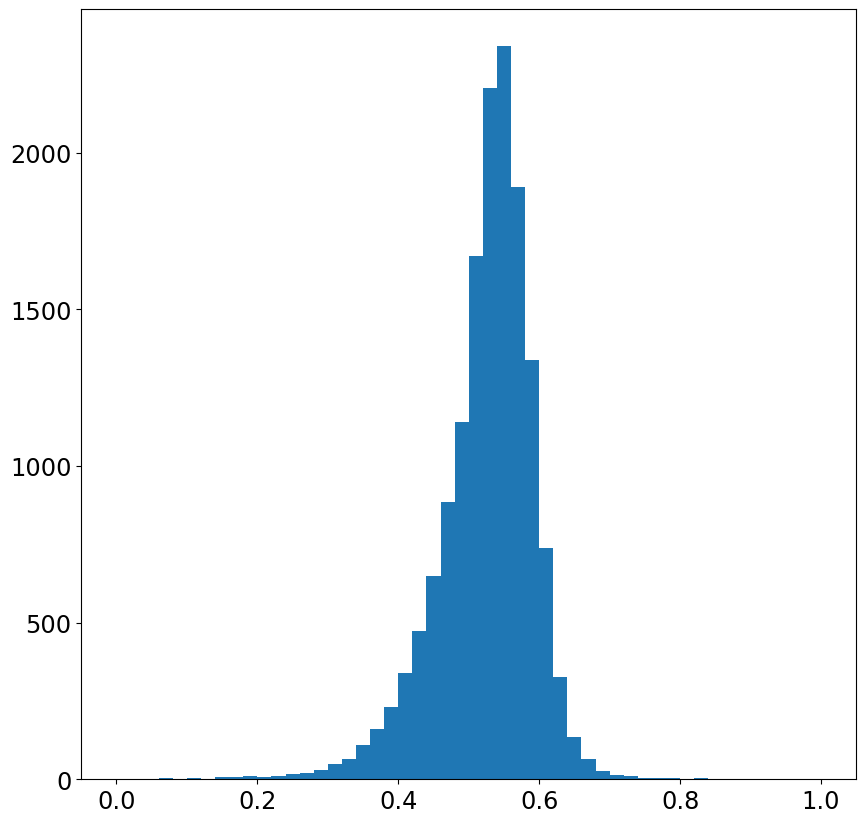

In [72]:
plt.hist(pair_residue_info['Pair_Score'], bins=50)

In [73]:
#calculate total score for each pair
#weights for relative contribution of single residue and pair resid information
pair_vs_single_weights=[1.,.5,.5]
Res1Score=[]
Res2Score=[]
for i in range(len(pair_residue_info)):
    Res1Score.append(single_residue_info[single_residue_info['Residue Index']==pair_residue_info['Residue Pair'][i][0]]['Single_Score'].iloc[0])
    Res2Score.append(single_residue_info[single_residue_info['Residue Index']==pair_residue_info['Residue Pair'][i][1]]['Single_Score'].iloc[0])

pair_residue_info['Residue 1 Score']=Res1Score
pair_residue_info['Residue 2 Score']=Res2Score
pair_residue_info['Total Score']=score_parameters(pair_residue_info[pair_residue_info['Good List']==True][['Pair_Score', 'Residue 1 Score', 'Residue 2 Score']], weights=pair_vs_single_weights, standardize_score='0to1')['Score']



In [74]:
def CoProximity_Penalty(Pair1, Pair2, width, coincidence_boon=1., norm='peakto1'):
    penalty=0.
    difs=[i-j for i, j in zip(Pair1, Pair2)]
    if difs==[0 for i in difs]:
        penalty+=np.inf
    for i in difs:
        if i==0:
            penalty-=coincidence_boon*gaussian(0,0,width,norm)
        else:
            penalty+=gaussian(i, 0, width, norm)
    return penalty

In [75]:
#do selection of top X complementary FRET pairs via forward greedy approach. Select best scorer first, then add additional ones until X pairs added
ranked_candidates=pair_residue_info[pair_residue_info['Good List']].sort_values('Total Score')

Num_Pairs=10
CoProximity_Penalty_Width=20. #penalty for two sites in complementary pairs being near each other, but non-identical (shared nodes are good, but not neighboring nodes)
#for the following functions, max and min judge based on each pairs worst/best performance respectively, mean and sum based on average performance
CoProximity_Penalty_fun=lambda x: np.max(x)     #can be changed to min, max, mean, sum depending on which value should be used to penalize the complentarity score based Co-Proximity of labeling sites
Coincidence_Boon=.1
dot_prod_penalty_fun=lambda x: np.max(x)     #can be changed to min, max, mean, sum depending on which value should be used to penalize the complentarity score based on alignment of Rmp vectors
dot_prod_among_states=lambda x: np.max(x)     #can be changed to min, max, mean, sum depending on which value should be used as the dot product between pairs amongst the dot products calculated for each state 
CoProximityWeight=1. #weight applied to CoProximity
DotProdWeight=1.


CompscoreMethod=lambda x, y: np.add(x,y) #should be either sum or multiply. Should be sum because otherwise negatives get funky

ScoreMethod=lambda x, y: np.add(x,y) #should be either sum (add score and compscore together, in which case ScoreWeight matters) or multiply (in which case compscore is a modifier to the original score, and weight doesnt matter. negatives fine if Total Score set to 0to1)
ScoreWeight=2. #weight applied to the score


keep_list=[]
keep_list.append(ranked_candidates.iloc[0])
while len(keep_list)<Num_Pairs:
    best=(None, np.inf) #best additional pair based on the criteria tested for complementarity
    for j in range(len(ranked_candidates)):
        #no repeat pairs allowed
        if ranked_candidates['Residue Pair'].iloc[j] in [k['Residue Pair'] for k in keep_list]:
            continue
        compscore=1.
        #applies penalty based on co-incidence of labeling sites in-exactly with ones already in the list
        compscore=CompscoreMethod(compscore, CoProximityWeight*CoProximity_Penalty_fun([CoProximity_Penalty(ranked_candidates['Residue Pair'].iloc[j], k['Residue Pair'], CoProximity_Penalty_Width, coincidence_boon=Coincidence_Boon) for k in keep_list]))
        #normalized dot product calculations of candidate pair against all other pairs, and for all states
        compscore=CompscoreMethod(compscore, DotProdWeight*dot_prod_penalty_fun([dot_prod_among_states([np.sum(m[0]*m[1])*sum(m[0]**2.)**(-.5)*sum(m[1]**2.)**(-.5) for m in l]) for l in [zip(ranked_candidates['Rmp_vec'].iloc[j], k['Rmp_vec']) for k in keep_list]]))
        #incorporate in the pair's score itself, either additively or multiplicatively
        compscore=ScoreMethod(compscore, ScoreWeight*ranked_candidates['Total Score'].iloc[j])
        
        if compscore<best[1]:
            best=(j, compscore)
            
    keep_list.append(ranked_candidates.iloc[best[0]])
    
Final_Network=pd.concat(keep_list, axis=1).T

In [76]:
Final_Network

Residue Pair Good List DCA Mutual Info DCA Direct Info  \
13564    (56, 256)      True        0.164354        0.012796   
20904    (94, 167)      True        0.226719        0.021962   
20993    (94, 256)      True        0.189615         0.02006   
3069     (12, 167)      True        0.244888        0.018287   
20859    (94, 122)      True        0.217154        0.027062   
3158     (12, 256)      True        0.210938        0.015854   
13475    (56, 167)      True        0.165221        0.022208   
13430    (56, 122)      True        0.150058          0.0127   
20940    (94, 203)      True        0.206431         0.01631   
13511    (56, 203)      True        0.138181        0.016793   

      Contacts RBP_open_fromSBM+DCA.pdb (nm)  \
13564                               2.582908   
20904                               4.138353   
20993                               4.631302   
3069                                3.815336   
20859                               1.087934   
3158                                0.305996   
13475                               1.819446   
13430                               1.411758   
20940                               1.194322   
13511                                3.74411   

      Contacts RBP_Twisted_allatom.pdb (nm)  \
13564                              2.612384   
20904                               4.05541   
20993                              4.592083   
3069                               4.123183   
20859                              0.938218   
3158                               0.280491   
13475                               1.77899   
13430                              1.366357   
20940                              1.142444   
13511                              3.597478   

                                                Contacts Mean Contacts  \
13564  [2.5829076766967773, 2.6123838424682617, 2.736...     -2.643976   
20904  [4.138352870941162, 4.055409908294678, 4.02243...     -4.072066   
20993  [4.631302356719971, 4.592082977294922, 4.26130...     -4.494896   
3069   [3.815335988998413, 4.123182773590088, 3.18251...     -3.707011   
20859  [1.0879335403442383, 0.9382181167602539, 1.016...     -1.014239   
3158   [0.30599647760391235, 0.280491441488266, 0.319...     -0.302152   
13475  [1.8194464445114136, 1.7789899110794067, 1.872...     -1.823538   
13430  [1.4117581844329834, 1.366356611251831, 1.4219...     -1.400035   
20940  [1.194321870803833, 1.1424444913864136, 1.2145...     -1.183784   
13511  [3.744109869003296, 3.597478151321411, 3.16602...     -3.502537   

                                    Al488C5-Al647C2_FRET  \
13564  [<fretraj.cloud.FRET object at 0x14778b7b06a0>...   
20904  [<fretraj.cloud.FRET object at 0x14778cb420d0>...   
20993  [<fretraj.cloud.FRET object at 0x14778cb01040>...   
3069   [<fretraj.cloud.FRET object at 0x14778e22c460>...   
20859  [<fretraj.cloud.FRET object at 0x14778cfae8e0>...   
3158   [<fretraj.cloud.FRET object at 0x14779e2f9040>...   
13475  [<fretraj.cloud.FRET object at 0x147795f848e0>...   
13430  [<fretraj.cloud.FRET object at 0x14778dfffbe0>...   
20940  [<fretraj.cloud.FRET object at 0x14778cb6c460>...   
13511  [<fretraj.cloud.FRET object at 0x147795f97b20>...   

                                                 Rmp_vec  ... avg_d_R_mp  \
13564  [[5.841935450177516, 5.065851171834993, -32.12...  ...  -1.651483   
20904  [[-26.80233640871063, -26.13482459870727, 13.8...  ... -10.613763   
20993  [[19.2166300511833, -17.116770151635706, -11.4...  ...  -0.508687   
3069   [[-11.875543984796309, 7.0556369782904085, 0.3...  ... -11.876694   
20859  [[-33.39984049125883, -20.38698865134586, -28....  ...  -3.358189   
3158   [[34.14342247509762, 16.07369142536197, -24.91...  ...  -0.924521   
13475  [[-40.177031009716416, -3.9522032752365703, -6...  ...  -8.275867   
13430  [[-46.774535092264614, 1.7956326721248388, -49...  ...  -1.859613   
20940  [[-39.78018416894645, -36.580750751332744, 3.1...  ... -10.126585   
13511  [[-53.15487

ValueError: keyword grid_b is not recognized; valid keywords are ['size', 'width', 'color', 'tickdir', 'pad', 'labelsize', 'labelcolor', 'zorder', 'gridOn', 'tick1On', 'tick2On', 'label1On', 'label2On', 'length', 'direction', 'left', 'bottom', 'right', 'top', 'labelleft', 'labelbottom', 'labelright', 'labeltop', 'labelrotation', 'grid_agg_filter', 'grid_alpha', 'grid_animated', 'grid_antialiased', 'grid_clip_box', 'grid_clip_on', 'grid_clip_path', 'grid_color', 'grid_dash_capstyle', 'grid_dash_joinstyle', 'grid_dashes', 'grid_data', 'grid_drawstyle', 'grid_figure', 'grid_fillstyle', 'grid_gapcolor', 'grid_gid', 'grid_in_layout', 'grid_label', 'grid_linestyle', 'grid_linewidth', 'grid_marker', 'grid_markeredgecolor', 'grid_markeredgewidth', 'grid_markerfacecolor', 'grid_markerfacecoloralt', 'grid_markersize', 'grid_markevery', 'grid_mouseover', 'grid_path_effects', 'grid_picker', 'grid_pickradius', 'grid_rasterized', 'grid_sketch_params', 'grid_snap', 'grid_solid_capstyle', 'grid_solid_joinstyle', 'grid_transform', 'grid_url', 'grid_visible', 'grid_xdata', 'grid_ydata', 'grid_zorder', 'grid_aa', 'grid_c', 'grid_ds', 'grid_ls', 'grid_lw', 'grid_mec', 'grid_mew', 'grid_mfc', 'grid_mfcalt', 'grid_ms']

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

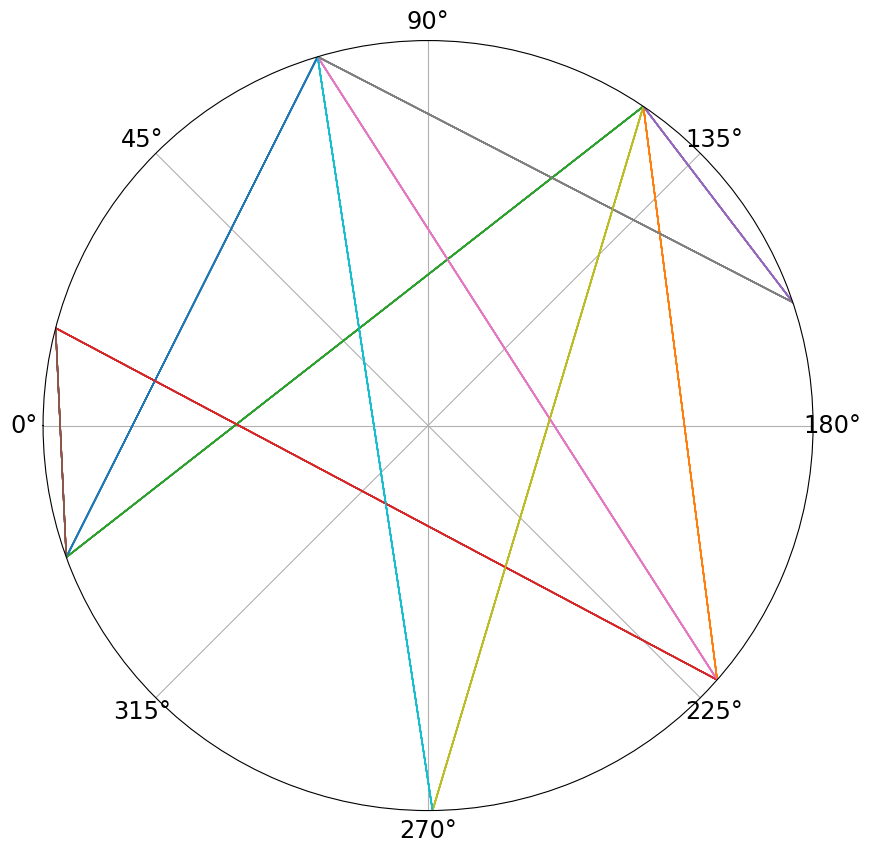

In [77]:
ax=plt.subplot(111,projection='polar')
firstres=single_residue_info['Residue Index'].iloc[0]
lastres=single_residue_info['Residue Index'].iloc[-1]
pairlist=np.array([[i[0],i[1]] for i in Final_Network['Residue Pair']]).astype(float).T
for i in Final_Network['Residue Pair']:
    ax.plot((pairlist-firstres)/(lastres-firstres)*2*np.pi,[1,1])
ax.set_rmax(1)
ax.set_theta_zero_location("W")
ax.set_theta_direction(-1)
ax.set_rticks([])
plt.grid(b=None)
plt.thetagrids((pairlist.flatten()-firstres)/(lastres-firstres)*360, labels=pairlist.flatten().astype(int))
plt.savefig('Network.png')
plt.show()

In [78]:
To_Save_List=Final_Network[['Residue Pair', 'DCA Direct Info', 'avg_Dynamic_Shift', 'Pair_Score', 'Residue 1 Score', 'Residue 2 Score', 'Total Score']]
To_Save_List.to_csv('Pair_List.csv', index=False)

Text(0.5, 0, 'Index')

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

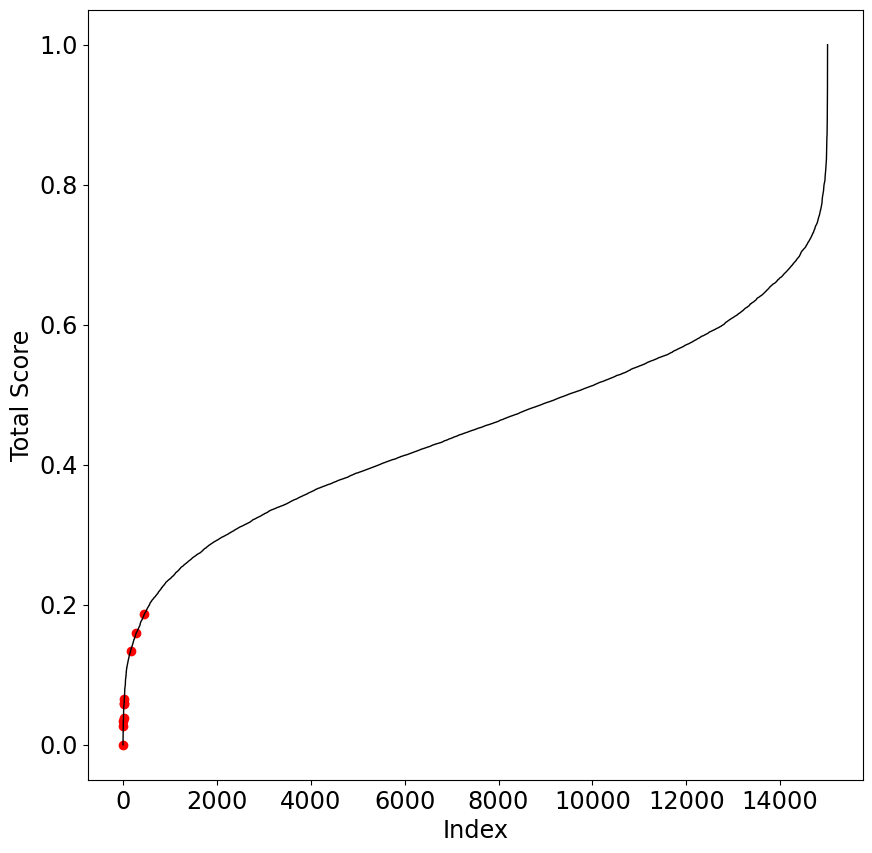

In [79]:
plt.plot(np.arange(len(pair_residue_info['Total Score'][pair_residue_info['Total Score'].notna()])),pair_residue_info['Total Score'][pair_residue_info['Total Score'].notna()].sort_values(), color='black', linewidth=1)

indices=[]
for i in Final_Network['Residue Pair']:
    indices.append((pair_residue_info[pair_residue_info['Total Score'].notna()].sort_values('Total Score')['Residue Pair']).tolist().index(i))
plt.scatter(indices, Final_Network['Total Score'], color='red')


plt.ylabel('Total Score')
plt.xlabel('Index')

(array([  4.,   8.,  13.,  14.,  27.,  44.,  80.,  93., 131., 150., 213.,
        270., 313., 378., 474., 534., 589., 629., 727., 768., 817., 796.,
        836., 756., 807., 788., 707., 708., 568., 550., 409., 360., 334.,
        292., 237., 194., 133.,  97.,  49.,  38.,  34.,  19.,   4.,   9.,
          3.,   1.,   3.,   1.,   0.,   1.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]),
 <BarContainer object of 50 artists>)

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

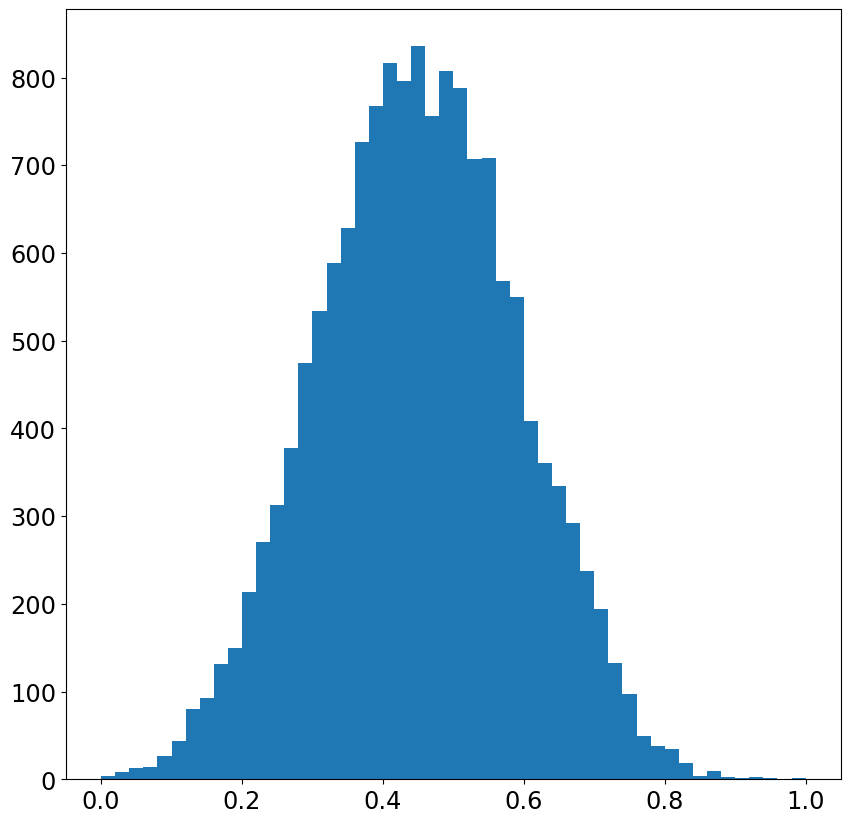

In [80]:
plt.hist(pair_residue_info['Total Score'], bins=50)